# Libraries import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from keras import backend as K

NLTK data that must be downloaded only once

In [2]:
# nltk.download('wordnet')
# nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Dataset with review loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_full = pd.read_csv('/content/drive/MyDrive/Sentiment model based on phones review/phones.csv')

In [5]:
df_full.head(5)

,Review,Rating
0,3D Touch просто восхитительная вещь! Заряд дер...,5
1,"Отключается при температуре близкой к нулю, не...",4
2,"В Apple окончательно решили не заморачиваться,...",3
3,Постарался наиболее ёмко и коротко описать все...,4
4,Достойный телефон. Пользоваться одно удовольст...,5


# Cleaning the dataset

In [6]:
df_full['Rating'].value_counts()

5    228517
4    106568
3     53091
2     35724
1     34529
0         2
9         1
7         1
Name: Rating, dtype: int64

Deleting rows with Rating more than 5 and lower than 1

In [7]:
df_full = df_full.drop(df_full[df_full.Rating < 1].index)
df_full = df_full.drop(df_full[df_full.Rating > 5].index)

# Loading dataset that made from sample of reviews from marketplace

In [8]:
df_extended = pd.read_csv('/content/drive/MyDrive/Sentiment model based on phones review/all_data.csv')

In [9]:
df_extended = df_extended.drop(columns=['date_time', 'color', 'size', 'thumb_up', 'thumb_down', 'prod', 'brand']).rename(columns={'comment':'Review', 'prod_eval':'Rating'})

Rating checking

In [10]:
df_extended['Rating'].value_counts()

5    171131
1     16022
4     14504
3     10650
2      6252
Name: Rating, dtype: int64

# Concatenation of datasets

In [11]:
df = pd.concat([df_full, df_extended]).drop_duplicates().reset_index().drop('index', axis = 1)

In [12]:
df['Review'] = df['Review'].astype('str')

# Converting grades to Positive / Negative view and encoding

In [13]:
df['Sentiment'] = np.where(df['Rating'] >= 4, 'Positive', 'Negative')

In [14]:
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['Sentiment'])

In [15]:
df['Sentiment'].value_counts()

Positive    395855
Negative    115070
Name: Sentiment, dtype: int64

# Lemmatiation and tokenization of comments using NLTK library

In [16]:
def preprocessing_for_sent(df):
    '''
    The function lemmatizes and tokenizes reviews from dataset
    '''
    wn_lemmatizer = WordNetLemmatizer()
    lemmatized_text_for_sen = []
    for comment in df['Review']:
        lemmatized_text_for_sen.append(' '.join([wn_lemmatizer.lemmatize(word) for word in comment.split()]))
    
    for i in range(len(lemmatized_text_for_sen)):
        lemmatized_text_for_sen[i] = word_tokenize(lemmatized_text_for_sen[i])
    clean_tokenized_comment = [] 
    for i, element in enumerate(lemmatized_text_for_sen):
        clean_tokenized_comment.append(' '.join([word for word in element]))    
    return pd.Series(clean_tokenized_comment)

In [17]:
new_review = preprocessing_for_sent(df)

In [18]:
df_cleaned = pd.concat([new_review, df.sentiment_encoded], axis=1).rename(columns={0:'Review', 'sentiment_encoded':'Sentiment'})

# Training the model

Functions for metrics calculation

In [19]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Function for plot with metrics displaying

In [20]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Test-train split

In [21]:
x_train, x_valid, y_train, y_valid = train_test_split(df_cleaned.Review, df_cleaned.Sentiment, test_size = 0.15)

Model's parameters setting

In [22]:
VOCAB_SIZE = 30000
BATCH_SIZE = 64
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(x_train.values)
vocab = np.array(encoder.get_vocabulary())

Model architecture setting and compiling

In [23]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, )),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy', tf.keras.metrics.BinaryAccuracy(), 
                       f1_m, recall_m, precision_m
                       ])

Model training

In [25]:
history = model.fit(x=x_train, y=y_train, validation_data=(x_valid, y_valid), epochs=3)

Epoch 1/3
13572/13572 [==============================] - 1180s 85ms/step - loss: 0.2748 - accuracy: 0.8822 - binary_accuracy: 0.8822 - f1_m: 0.9238 - recall_m: 0.9406 - precision_m: 0.9108 - val_loss: 0.2445 - val_accuracy: 0.8943 - val_binary_accuracy: 0.8943 - val_f1_m: 0.9298 - val_recall_m: 0.9231 - val_precision_m: 0.9393
Epoch 2/3
13572/13572 [==============================] - 1153s 85ms/step - loss: 0.2001 - accuracy: 0.9186 - binary_accuracy: 0.9186 - f1_m: 0.9467 - recall_m: 0.9534 - precision_m: 0.9423 - val_loss: 0.2270 - val_accuracy: 0.9056 - val_binary_accuracy: 0.9056 - val_f1_m: 0.9384 - val_recall_m: 0.9464 - val_precision_m: 0.9329
Epoch 3/3
13572/13572 [==============================] - 1151s 85ms/step - loss: 0.1525 - accuracy: 0.9399 - binary_accuracy: 0.9399 - f1_m: 0.9606 - recall_m: 0.9651 - precision_m: 0.9577 - val_loss: 0.2325 - val_accuracy: 0.9108 - val_binary_accuracy: 0.9108 - val_f1_m: 0.9418 - val_recall_m: 0.9504 - val_precision_m: 0.9356


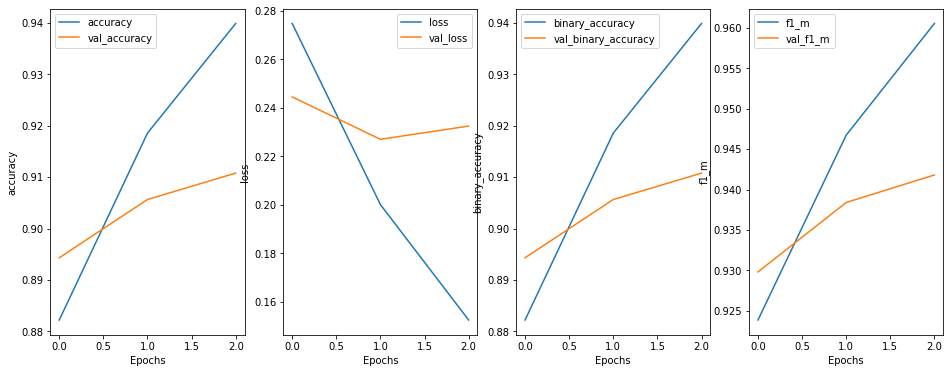

In [26]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 4, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 4, 2)
plot_graphs(history, 'loss')
plt.subplot(1, 4, 3)
plot_graphs(history, 'binary_accuracy')
plt.subplot(1, 4, 4)
plot_graphs(history, 'f1_m')

# Model saving

In [27]:
model.save('/content/drive/MyDrive/Sentiment model based on phones review/Model_full_extended_final')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Sentiment model based on phones review/Model_full_extended_final/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Sentiment model based on phones review/Model_full_extended_final/assets
